In [1]:
import signal, time
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from logicmodel import Model

In [2]:
def genData(NX=3, num_active_tfs=2, NY=50):
    # Start generating simulated data
    # The TFs: Number of TF and activation state of each

    # the target genes: Number of target genes and state of each
    
    Xgt = dict(zip(list(range(NX)), [0]*NX))
    Y = dict(zip(list(range(NX,NX+NY)), [0]*NY))
    
    # generate a random set of interations between TFs and genes
    edges = {}
    for trg in Y.keys():
        
        # randomize the number of TFs for this gene
        num_edges = np.random.binomial(NX, 1.0/4)

        # pick random TFs
        for src in np.random.choice(list(Xgt.keys()), size=num_edges, replace=False):
            # here an edge can be upregulator (1), downregulator (-1) or not valid (0)
            edges[(src, trg)] = np.random.choice([-1, 0, 1], p=[0.3, 0.4, 0.3])

    # randomize current activation state for TFs
    # and then determine the state of targeted genes
    for src in np.random.choice(list(Xgt.keys()), size=num_active_tfs, replace=False):
        # either active (1) or inactive (0)
        Xgt[src] = 1

    for src in Xgt.keys():
        for trg in Y.keys():
            edge = src, trg
            if edge in edges.keys():
                if edges[edge] < 0 and Xgt[src] > 0:
                    # if TF is inhibitor, make sure the response is definitive
                    Y[trg] += edges[edge]*Xgt[src]*10000
                else:
                    Y[trg] += edges[edge]*Xgt[src]

    # get only the signs for gene activation states
    for trg in Y.keys():
        Y[trg] = np.sign(Y[trg])
        
    # this is the possible associations data
    rels = pd.DataFrame(list(edges.keys()), columns=['srcuid', 'trguid'])
    rels = rels.assign(val=list(edges.values()))

    # extract a dataframe that only contains relevant interactions
    rels = rels[rels['trguid'].isin(Y.keys())]
    rels = rels.assign(edge=[(src, trg) for src, trg in zip(rels['srcuid'], rels['trguid'])])
    rels = rels.assign(srcactive=[Xgt[src] for src in rels['srcuid']])
    rels = rels.set_index('edge')

    return Xgt, Y, rels

In [3]:
def processTrace(model, dictionaries):
    
    Dx, ADx, Ds, ADs, Dy = dictionaries
    
    Xres = model.get_result('X')
    Xres = Xres.assign(srcuid=[ADx[i] for i in range(len(Dx))])
    Xres = Xres.set_index('srcuid')
    Xres = Xres.assign(ground_truth=[Xgt[src] for src in Xres.index])

    Rres = model.get_result('R')
    Rres = Rres.assign(edge=[ADs[i] for i in range(len(Ds))])
    Rres = Rres.set_index('edge')
    Rres = Rres.assign(srcuid=[src for src, trg in Rres.index])
    Rres = Rres.assign(trguid=[trg for src, trg in Rres.index])
    Rres = Rres[Rres['srcuid'].isin(Xres.index)]
    Rres = Rres.assign(ground_truth=[abs(rels.loc[[edge], 'val'])[0] for edge in Rres.index])

    Sres = model.get_result('S')
    Sres = Sres.assign(edge=[ADs[i] for i in range(len(Ds))])
    Sres = Sres.set_index('edge')
    Sres = Sres.assign(srcuid=[src for src, trg in Sres.index])
    Sres = Sres.assign(trguid=[trg for src, trg in Sres.index])
    Sres = Sres[Sres['srcuid'].isin(Xres.index)]
    Sres = Sres.assign(ground_truth=[rels.loc[[edge], 'val'][0] for edge in Sres.index])
    
    Xres = Xres.sort_values(by=['mean'])
    Rres = Rres.sort_values(by=['mean'])
    Sres = Sres.sort_values(by=['mean'])
    
    return Xres, Rres, Sres
    

In [4]:
def updateRes(Xres, Rres, Sres, dictionaries, lenient=[False, False, False], final=False):
    Dx, ADx, Ds, ADs, Dy = dictionaries
    lenientX, lenientR, lenientS = lenient
    
    if final:
        conditions = [Xres['mean'] < 0.45, Xres['mean'] >= 0.7]
    elif lenientX:
        conditions = [Xres['mean'] < 0.4, Xres['mean'] >= 0.8]
    else:
        conditions = [Xres['mean'] < 0.2, Xres['mean'] >= 0.8]
    choices = [0, 1]
    Xres = Xres.assign(pred=np.select(conditions, choices, default=-99))
    Xres = Xres.assign(correctness=Xres['ground_truth']==Xres['pred'])
    
    if final:
        conditions = [Rres['mean'] < 0.40, Rres['mean'] >= 0.60]
    elif lenientR:
        conditions = [Rres['mean'] < 0.35, Rres['mean'] >= 0.65]
    else:
        conditions = [Rres['mean'] < 0.30, Rres['mean'] >= 0.70]
    choices = [0, 1]
    Rres = Rres.assign(pred=np.select(conditions, choices, default=-99))
    Rres = Rres.assign(correctness=Rres['ground_truth']==Rres['pred'])
    Rres = Rres.assign(srcactive=[Xres.loc[src]['pred'] for src in Rres['srcuid']])
    Rres = Rres[Rres['srcactive']>0]

    if final:
        conditions = [Sres['mean'] < 0.40, Sres['mean'] >= 0.60]
    elif lenientS:
        conditions = [Sres['mean'] < 0.35, Sres['mean'] >= 0.65]
    else:
        conditions = [Sres['mean'] < 0.30, Sres['mean'] >= 0.70]
    choices = [-1, 1]
    Sres = Sres.assign(prediction=np.select(conditions, choices, default=0))
    choices = [0, 1]
    Sres = Sres.assign(pred=np.select(conditions, choices, default=-99))
    Sres = Sres.assign(correctness=Sres['ground_truth']==Sres['prediction'])
    Sres = Sres.assign(srcactive=[Xres.loc[src]['pred'] for src in Sres['srcuid']])
    Sres = Sres[Sres['srcactive']>0]
    Sres = Sres[Sres.index.isin(Rres.index)]
    
    if len(Sres) > 0:
        # I think this might break. Be careful when rows differ in both dfs
        Sres['applicable'] = Rres['pred']
        Sres = Sres[Sres['applicable']>0]
    
    if not final:
        Xres = Xres[Xres['pred']!=-99]
        Rres = Rres[Rres['pred']!=-99]
        Sres = Sres[Sres['prediction']!=0]
    
    return Xres, Rres, Sres

In [5]:
Xgt, Y, rels = genData(3, 2, 50)

In [6]:
origY = Y.copy()

In [ ]:
#Y = origY.copy()
## test 1: all zeros at output
#for key, val in Y.items():
#    Y[key] = 0

In [ ]:
#Y = origY.copy()
## test 2: add noise to data
#for key, val in Y.items():
#    Y[key] = int(round(val*np.random.uniform(0.3, 1.0)))

In [ ]:
#ndiff = 0
#for key in origY.keys():
#    ndiff += int(Y[key] != origY[key])
#ndiff

In [8]:
model = Model()
model.scale = [0.5]
model.build(Y, rels)

alph, beta = 0.4, 0.7
x_alph = np.ones(shape=model.nx)*alph
x_beta = np.ones(shape=model.nx)*beta

r_alph = np.ones(shape=model.ns)*alph
r_beta = np.ones(shape=model.ns)*beta

alph, beta = 0.5, 0.5
s_alph = np.ones(shape=model.ns)*alph
s_beta = np.ones(shape=model.ns)*beta

Xprior = st.beta(x_alph, x_beta)
Rprior = st.beta(r_alph, r_beta)
Sprior = st.beta(s_alph, s_beta)

model.set_priors(Xprior, Rprior, Sprior)
model.init_chains(chains=2)

In [9]:
model.sample(N=2000, burn=1000, njobs=2)


Sampling 2 chains in 2 jobs
Chain 0 - Acceptance rate  38.76%, Sampling completed
Chain 1 - Acceptance rate  37.21%, Sampling completed
Progress  100.00%

In [10]:
while not model.converged():
    model.sample(N=2000, burn=1000, njobs=2)


Failed to converge. Gelman-Rubin statistics was   1.424 for some parameter

Sampling 2 chains in 2 jobs
Chain 1 - Acceptance rate  35.66%, Sampling completed
Chain 0 - Acceptance rate  42.64%, Sampling completed
Progress  100.00%
Failed to converge. Gelman-Rubin statistics was   1.297 for some parameter

Sampling 2 chains in 2 jobs
Chain 1 - Acceptance rate  38.76%, Sampling completed
Chain 0 - Acceptance rate  40.31%, Sampling completed
Progress  100.00%
Failed to converge. Gelman-Rubin statistics was   1.132 for some parameter

Sampling 2 chains in 2 jobs
Chain 0 - Acceptance rate  31.01%, Sampling completed
Chain 1 - Acceptance rate  38.76%, Sampling completed
Progress  100.00%
Chains have converged


In [11]:
model.gelman_rubin['X'].max()

1.0051987949307999

In [12]:
model.gelman_rubin['R'].max()

1.0340631725925207

In [13]:
model.gelman_rubin['S'].max()

1.0682654507100775

In [14]:
model.get_trace('X').shape

(2, 7001, 3)

In [15]:
model.scale

[0.5]

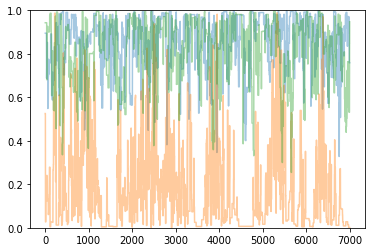

In [16]:
y = model.get_trace('X', chain=0)
for i in range(y.shape[1]):
    plt.plot(range(y.shape[0]), y[:, i], alpha=0.4)
plt.ylim(0,1)
plt.show()


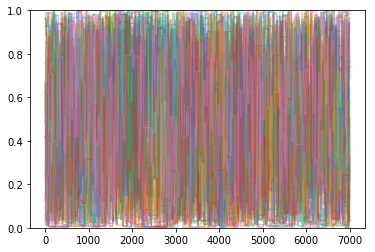

In [17]:
y = model.get_trace('R', chain=0)
for i in range(y.shape[1]):
    plt.plot(range(y.shape[0]), y[:, i], alpha=0.4)
plt.ylim(0,1)
plt.show()


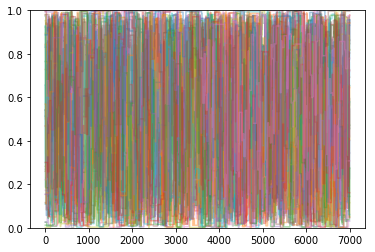

In [18]:
y = model.get_trace('S', chain=0)
for i in range(y.shape[1]):
    plt.plot(range(y.shape[0]), y[:, i], alpha=0.4)
plt.ylim(0,1)
plt.show()


In [19]:
Xres, Rres, Sres = processTrace(model, model.dictionaries)

In [20]:
Xres, Rres, Sres = updateRes(Xres, Rres, Sres, model.dictionaries, final=True)

In [21]:
Xres

,mean,std,ground_truth,pred,correctness
srcuid,,,,,
0,0.181208,0.190291,0,0,True
2,0.835381,0.142758,1,1,True
1,0.859272,0.126655,1,1,True


In [22]:
Rres

,mean,std,srcuid,trguid,ground_truth,pred,correctness,srcactive
edge,,,,,,,,
"(1, 19)",0.229218,0.249693,1,19,0,0,True,1
"(1, 25)",0.234825,0.245767,1,25,0,0,True,1
"(1, 17)",0.259849,0.265328,1,17,0,0,True,1
"(1, 3)",0.270361,0.262421,1,3,0,0,True,1
"(2, 24)",0.276011,0.247706,2,24,0,0,True,1
"(1, 13)",0.282384,0.256828,1,13,0,0,True,1
"(1, 6)",0.399169,0.289481,1,6,1,0,False,1
"(1, 35)",0.424671,0.309726,1,35,1,-99,False,1
"(2, 35)",0.429807,0.301747,2,35,1,-99,False,1


In [23]:
Sres

,mean,std,srcuid,trguid,ground_truth,prediction,pred,correctness,srcactive,applicable
edge,,,,,,,,,,
"(1, 20)",0.280064,0.256451,1,20,-1,-1,0,True,1,1
"(1, 21)",0.285307,0.251991,1,21,-1,-1,0,True,1,1
"(1, 22)",0.708318,0.243956,1,22,1,1,1,True,1,1
"(2, 51)",0.709078,0.246493,2,51,1,1,1,True,1,1
"(2, 30)",0.713419,0.238144,2,30,1,1,1,True,1,1
"(1, 12)",0.714561,0.247590,1,12,1,1,1,True,1,1
"(2, 40)",0.720263,0.248596,2,40,1,1,1,True,1,1
"(2, 11)",0.725847,0.239450,2,11,1,1,1,True,1,1
"(1, 18)",0.728382,0.247232,1,18,1,1,1,True,1,1
